## Notebook 2 – Step 1: Load Cleaned Data for Modeling

This cell reads in the cleaned CIDDS dataset saved in `data/processed/`, prints its shape, and displays the first few rows to confirm it’s ready for feature preparation.

In [2]:
import pandas as pd  # for data loading

# Load the cleaned dataset from the processed folder
df = pd.read_csv("../data/processed/cidds_week1_cleaned.csv")

# Verify the number of records and features
print("Dataset shape:", df.shape)

# Show the first five rows to inspect feature columns
df.head()

Dataset shape: (156950, 16)


,Date first seen,Duration,Proto,Src IP Addr,Src Pt,Dst IP Addr,Dst Pt,Packets,Bytes,Flows,Flags,Tos,class,attackType,label,predicted_anomaly
0,2017-03-14 17:43:57.172,81412.697,TCP,EXT_SERVER,8082,OPENSTACK_NET,56978.0,3057,2100000.0,1,.AP...,0,normal,---,0,1
1,2017-03-14 17:43:57.172,81412.697,TCP,OPENSTACK_NET,56978,EXT_SERVER,8082.0,4748,2500000.0,1,.AP...,0,normal,---,0,1
2,2017-03-14 17:43:26.135,81504.787,TCP,EXT_SERVER,8082,OPENSTACK_NET,56979.0,8639,9100000.0,1,.AP...,0,normal,---,0,1
3,2017-03-14 17:43:26.135,81504.787,TCP,OPENSTACK_NET,56979,EXT_SERVER,8082.0,12024,10300000.0,1,.AP...,0,normal,---,0,1
4,2017-03-14 18:17:09.005,82100.692,TCP,EXT_SERVER,8082,OPENSTACK_NET,51649.0,11012,27200000.0,1,.AP.S.,0,normal,---,0,1


### Step 2: Feature Selection & Scaling

This cell selects the key numeric features (`Duration`, `Packets`, `Bytes`, `Flows`), fills any missing values with zero, and scales them to zero mean and unit variance using `StandardScaler`. Scaling ensures that no feature dominates the anomaly detection model due to its range.

In [3]:
from sklearn.preprocessing import StandardScaler  # for feature scaling
import pandas as pd                                 # for DataFrame handling

# Load cleaned data
df = pd.read_csv("../data/processed/cidds_week1_cleaned.csv")

# 1. Select numeric features and handle missing values
features = ["Duration", "Packets", "Bytes", "Flows"]
X = df[features].fillna(0)

# 2. Scale features to zero mean, unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Verify the scaled matrix
print("Scaled feature matrix shape:", X_scaled.shape)
pd.DataFrame(X_scaled, columns=features).head()

Scaled feature matrix shape: (156950, 4)


,Duration,Packets,Bytes,Flows
0,15.081883,12.459109,6.518965,0.0
1,15.081883,19.384219,7.764123,0.0
2,15.098961,35.318935,28.309219,0.0
3,15.098961,49.181441,32.044691,0.0
4,15.209472,45.037023,84.652588,0.0


### Step 3: Train Isolation Forest Anomaly Detector

This cell fits an Isolation Forest on the scaled feature matrix `X_scaled` to identify outliers (anomalies). We use the default contamination setting, which estimates the fraction of anomalies automatically.

In [4]:
from sklearn.ensemble import IsolationForest  # for anomaly detection

# 1. Initialize the model with a fixed random state for reproducibility
iso_forest = IsolationForest(random_state=42)

# 2. Fit the model on the scaled features
iso_forest.fit(X_scaled)

# 3. Predict on the same data (-1 = anomaly, 1 = normal)
predictions = iso_forest.predict(X_scaled)

# 4. Convert to binary labels (1 = anomaly, 0 = normal)
y_pred = (predictions == -1).astype(int)

# 5. Attach predictions to the DataFrame for review
df["predicted_anomaly"] = y_pred

# 6. Show how many points the model flagged as anomalies vs. normals
print(df["predicted_anomaly"].value_counts())

predicted_anomaly
0    135341
1     21609
Name: count, dtype: int64


### Step 5: Evaluate Model Against True Labels

Compute a confusion matrix and classification report to see precision/recall on “Attack” vs. “Normal.”

In [5]:
from sklearn.metrics import classification_report, confusion_matrix

# True labels (0=normal, 1=attack) vs. model predictions (0=normal, 1=anomaly)
y_true = df["label"]
y_pred = df["predicted_anomaly"]

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Normal","Attack"]))

Confusion Matrix:
[[48673   933]
 [86668 20676]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.36      0.98      0.53     49606
      Attack       0.96      0.19      0.32    107344

    accuracy                           0.44    156950
   macro avg       0.66      0.59      0.42    156950
weighted avg       0.77      0.44      0.39    156950



### Step 6: Verify True Label Encoding

This cell checks the distribution of the original `class` field and the derived binary `label` column to confirm we actually have any “attack” records encoded as 1.

In [6]:
# Inspect the original text labels
print("Unique values in 'class':")
print(df["class"].value_counts(), "\n")

# Inspect the binary label counts
print("Distribution of 'label' column:")
print(df["label"].value_counts())

Unique values in 'class':
class
suspicious    107344
normal         49606
Name: count, dtype: int64 

Distribution of 'label' column:
label
1    107344
0     49606
Name: count, dtype: int64


### Step 7: Evaluate Model Against True Labels

This cell computes a confusion matrix and classification report comparing the Isolation Forest’s anomaly flags (`predicted_anomaly`) against the true binary labels (`label`), so we can assess precision, recall, and F1‐score for detecting “suspicious” connections.

In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Reload the cleaned data with correct labels
df = pd.read_csv("../data/processed/cidds_week1_cleaned.csv")

# True labels (0 = normal, 1 = suspicious) and model predictions (0 = normal, 1 = anomaly)
y_true = df["label"]
y_pred = df["predicted_anomaly"]

# 1. Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# 2. Classification report
cr = classification_report(y_true, y_pred, target_names=["Normal","Suspicious"])
print("\nClassification Report:")
print(cr)

Confusion Matrix:
[[48673   933]
 [86668 20676]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.36      0.98      0.53     49606
  Suspicious       0.96      0.19      0.32    107344

    accuracy                           0.44    156950
   macro avg       0.66      0.59      0.42    156950
weighted avg       0.77      0.44      0.39    156950



### Step 8: Tune Contamination Parameter (Maximum Allowed)

The Isolation Forest’s `contamination` parameter must be ≤ 0.5. Since your true anomaly rate (~68%) exceeds that, we’ll set `contamination=0.5` (the maximum allowed) to increase sensitivity. This will flag half of the data as anomalies for review.

In [8]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report

# 1. Load the cleaned dataset and true labels
df = pd.read_csv("../data/processed/cidds_week1_cleaned.csv")
y_true = df["label"]

# 2. Prepare and scale features
features = ["Duration", "Packets", "Bytes", "Flows"]
X = df[features].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Initialize Isolation Forest with contamination=0.5
iso_tuned = IsolationForest(contamination=0.5, random_state=42)

# 4. Fit and predict
iso_tuned.fit(X_scaled)
y_pred_tuned = (iso_tuned.predict(X_scaled) == -1).astype(int)

# 5. Evaluate performance
print("Tuned Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_tuned))
print("\nTuned Classification Report:")
print(classification_report(y_true, y_pred_tuned, target_names=["Normal","Suspicious"]))

Tuned Confusion Matrix:
[[44837  4769]
 [33680 73664]]

Tuned Classification Report:
              precision    recall  f1-score   support

      Normal       0.57      0.90      0.70     49606
  Suspicious       0.94      0.69      0.79    107344

    accuracy                           0.76    156950
   macro avg       0.76      0.80      0.75    156950
weighted avg       0.82      0.76      0.76    156950



### Step 10: Correct Binary Label Encoding

The original encoding only looked for `"attack"` in `class`, but this dataset uses `"suspicious"` (and `"unknown"`). We’ll treat `"suspicious"` as anomalies (1) and `"normal"` as normal (0). We’ll drop or ignore `"unknown"` for clarity, or you can tag them as anomalies if you prefer.

In [9]:
# Work on a fresh copy of df_clean in Notebook 1
df_clean = df.copy()

# Option A: Drop unknown records, then encode
df_clean = df_clean[df_clean["class"].isin(["normal", "suspicious"])]
df_clean["label"] = (df_clean["class"] == "suspicious").astype(int)

# Option B (if you’d rather treat unknown as anomalies):
# df_clean["label"] = df_clean["class"].isin(["suspicious", "unknown"]).astype(int)

# Verify the new label distribution
print(df_clean["class"].value_counts())
print(df_clean["label"].value_counts())

class
suspicious    107344
normal         49606
Name: count, dtype: int64
label
1    107344
0     49606
Name: count, dtype: int64


### Save Updated Cleaned Data

This cell writes the re-labeled DataFrame `df_clean` (with `label` = 1 for “suspicious” and 0 for “normal”) back to your processed folder so that Notebook 2 will load the correct true labels.

In [10]:
import os

# Ensure processed directory exists
processed_dir = "../data/processed"
os.makedirs(processed_dir, exist_ok=True)

# Save the updated cleaned DataFrame
output_path = os.path.join(processed_dir, "cidds_week1_cleaned.csv")
df_clean.to_csv(output_path, index=False)

print(f"Updated cleaned data saved to: {output_path}")

Updated cleaned data saved to: ../data/processed/cidds_week1_cleaned.csv


### Inspect cleaned DataFrame
Let’s see which columns are available in `df_clean`.

In [14]:
# See all columns in the cleaned DataFrame
print(df_clean.columns.tolist())

['Date first seen', 'Duration', 'Proto', 'Src IP Addr', 'Src Pt', 'Dst IP Addr', 'Dst Pt', 'Packets', 'Bytes', 'Flows', 'Flags', 'Tos', 'class', 'attackType', 'label', 'predicted_anomaly']


## Setup for IsolationForest
In this cell we’ll select feature columns, split into train/test, and fit our tuned IsolationForest model.

In [15]:
# 1. Auto-select numeric features, dropping the true labels
numeric_cols = df_clean.select_dtypes(include="number").columns.tolist()
feature_cols = [col for col in numeric_cols if col not in ["label", "predicted_anomaly"]]
print("Using features:", feature_cols)

# 2. Prepare training and test sets
X = df_clean[feature_cols]
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)

# 3. Fit the tuned IsolationForest
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.3, random_state=42)
iso.fit(X_train)

Using features: ['Duration', 'Src Pt', 'Dst Pt', 'Packets', 'Bytes', 'Flows', 'Tos']


IsolationForest(contamination=0.3, random_state=42)

### Step 9: Plot anomaly‐score histogram

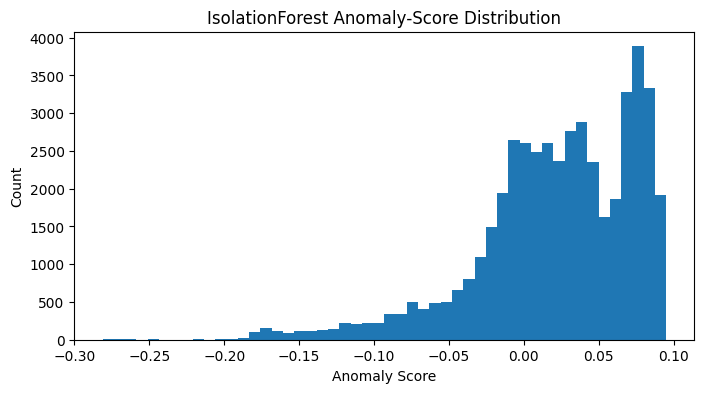

In [17]:
scores = iso.decision_function(X_test)
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.hist(scores, bins=50)
plt.title("IsolationForest Anomaly‐Score Distribution")
plt.xlabel("Anomaly Score")
plt.ylabel("Count")
plt.show()

In [18]:
# 3. Fit the tuned IsolationForest
iso = IsolationForest(contamination=0.3, random_state=42)
iso.fit(X_train)

# 4. Save it for later use
import joblib, os
os.makedirs("../models", exist_ok=True)        # make sure the folder exists
joblib.dump(iso, "../models/iso_tuned.pkl")
print("✅ Model saved to ../models/iso_tuned.pkl")

✅ Model saved to ../models/iso_tuned.pkl
